In [ ]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model training
from keras import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# 전처리 파트 (수정 가능)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jangedoo/utkface-new")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/utkface-new


In [ ]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 227

# 데이터셋 점검 (수정 가능)

Total number of images  : 23708
Sample Image path       : 1_0_3_20161220222642427.jpg.chip.jpg
Sample Age              : 1
Sample Gender           : Male



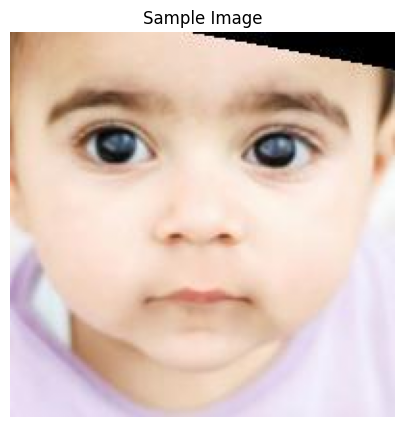

In [ ]:
# Initialize the directory path
dir_path = os.path.join(path, "UTKFace")
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(os.path.join(dir_path, rand_image_path)) / 255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

# 전처리 과정(파일 이름에서 라벨링, 수정 가능)

# 데이터셋 분할 (수정 가능)

In [ ]:
# 이미지 경로들을 무작위로 섞기 (재현 가능성 위해 시드 고정)
np.random.seed(42)
np.random.shuffle(image_paths)

# 1. 전체 데이터 → 학습/테스트 분할 (90% 학습용, 10% 테스트용)
train_valid_images, test_images = train_test_split(
    image_paths,
    train_size=0.9,
    test_size=0.1,
    random_state=42
)

# 2. 학습용 데이터 → 학습/검증 분할 (90% 학습용, 10% 검증용)
train_images, valid_images = train_test_split(
    train_valid_images,
    train_size=0.9,
    test_size=0.1,
    random_state=42
)

# 결과 확인
print(f"Training Size  : {len(train_images)}")
print(f"Validation Size: {len(valid_images)}")
print(f"Testing Size   : {len(test_images)}")

# 나이 및 성별 라벨 추출 함수
def extract_labels(image_list):
    ages = [int(path.split("_")[0]) for path in image_list]
    return ages

# 학습, 검증, 테스트 데이터에 대해 라벨 추출
train_ages = extract_labels(train_images)
valid_ages = extract_labels(valid_images)
test_ages = extract_labels(test_images)

Training Size  : 19203
Validation Size: 2134
Testing Size   : 2371


# 전처리 과정 (이미지를 텐서 형태로 변환)

In [ ]:
def show_image(image, show=False):
    """
    이미지를 시각화하는 함수입니다. 축은 제거되고,
    show=True일 경우에만 실제로 plt.show()로 출력합니다.

    Args:
    - image (array-like): 표시할 이미지 배열
    - show (bool): True이면 이미지 출력 (기본값: False)

    Returns:
    - None
    """
    plt.imshow(image)       # 이미지 시각화
    plt.axis("off")         # x, y 축 숨김

    if show:
        plt.show()          # show=True인 경우에만 출력

# ------------------------------------------------------------

def preprocess_age_data(image_path, age, dir_path=dir_path, IMAGE_SIZE=IMAGE_SIZE):
    """
    나이(age) 예측을 위한 이미지 전처리 함수입니다.
    JPEG 이미지 파일을 로드하고 크기 조정 및 정규화를 수행한 후,
    나이 값을 함께 반환합니다.

    Args:
    - image_path (str): 이미지 파일 이름
    - age (int): 라벨로 사용할 나이 값
    - gender (int): (사용되지 않지만, 필요시 활용 가능)
    - dir_path (str): 이미지가 저장된 디렉토리 경로
    - IMAGE_SIZE (int): 리사이징할 이미지 크기 (정사각형)

    Returns:
    - tuple: (전처리된 이미지, 나이)
    """
    def _load_image(path):
        path = path.numpy().decode("utf-8")  # bytes -> str
        full_path = os.path.join(dir_path, path)
        image = tf.io.read_file(full_path)
        image = tf.io.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
        image = tf.cast(image, tf.float32) / 255.0
        return image

    image = tf.py_function(_load_image, [image_path], tf.float32)
    image.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    return image, age

# 데이터셋 구성 (batch size로 자르기, prefetch)

In [ ]:
# (이미지 경로, 나이, 성별)을 튜플로 묶어 TensorFlow Dataset으로 변환 후 셔플
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages)).shuffle(2000)

# 나이 예측용 데이터셋: 이미지 전처리 및 age 반환 → 배치 & prefetch로 성능 향상
train_age_ds = train_ds.map(
    preprocess_age_data,                         # 이미지 전처리 + 나이 추출
    num_parallel_calls=BATCH_SIZE                # 병렬처리로 속도 향상
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)      # 배치 및 prefetch

# ------------------------------
# Validation Dataset 구성
# ------------------------------

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages)).shuffle(2000)

valid_age_ds = valid_ds.map(
    preprocess_age_data,
    num_parallel_calls=BATCH_SIZE
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

# ------------------------------
# Testing Dataset 구성
# ------------------------------

test_ds = tfds.Dataset.from_tensor_slices((test_images, test_ages)).shuffle(500)

test_age_ds = test_ds.map(
    preprocess_age_data,
    num_parallel_calls=BATCH_SIZE
).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

# 알맞은 형식으로 띄우기 (plt)

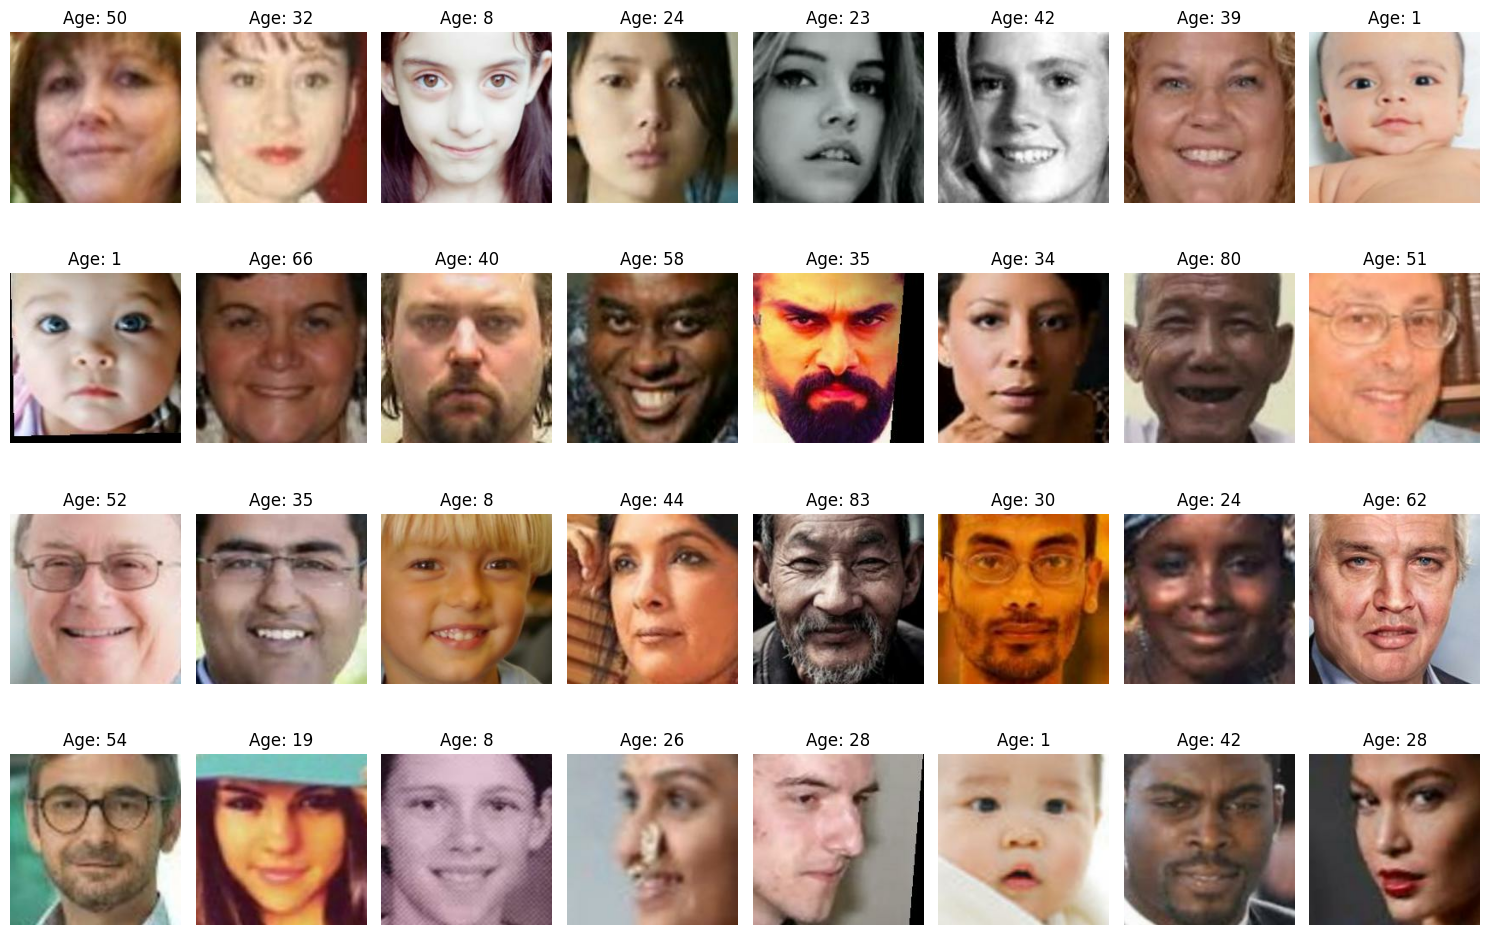

In [ ]:
# 이미지가 저장된 경로 (앞서 정의한 경로)
dir_path = "/kaggle/input/utkface-new/UTKFace/"

# 전체 이미지 플롯의 크기 설정 (가로 15인치, 세로 10인치)
plt.figure(figsize=(15, 10))

# train_ds에서 한 배치(BATCH_SIZE만큼)를 가져옴
for images, ages in train_ds.batch(BATCH_SIZE).take(1):

    # 해당 배치의 이미지 개수만큼 반복
    for index in range(len(images)):
        # 이미지 경로를 사용해 이미지 파일 로딩 및 디코딩
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)

        # 4행 8열 서브플롯에 이미지 시각화
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)

        # 이미지 상단에 나이와 성별 정보 표시
        plt.title(f"Age: {ages[index]}")

        # 축은 표시하지 않음
        plt.axis("off")

# 레이아웃 자동 정렬 (타이틀 겹침 방지)
plt.tight_layout()

# 플롯 출력
plt.show()

# 주어진 모델 훈련 AlexNet


In [ ]:
input_shape = (227, 227, 3)
model = Sequential()

#Conv1
model.add(Conv2D(96, (11, 11), strides=4, padding='valid', input_shape=input_shape)) # 55 x 55 x 96
model.add(MaxPooling2D(pool_size=(3, 3), strides=2)) # 27 x 27 x 96
model.add(BatchNormalization())

#Conv2
model.add(Conv2D(256, (5, 5), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))
model.add(BatchNormalization())

#Conv3
model.add(Conv2D(384, (3, 3), strides=1, activation='relu', padding='same'))

#Conv4
model.add(Conv2D(384, (3, 3), strides=1, activation='relu', padding='same'))

#Conv5
model.add(Conv2D(384, (3, 3), strides=1, activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

#Fully
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4096, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(117, activation='softmax'))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer='adam',
    weighted_metrics=[]
)

In [ ]:
for batch in train_age_ds.take(1):
    _, labels = batch
    print("Label dtype:", labels.dtype)
    print("Min label:", tf.reduce_min(labels).numpy())
    print("Max label:", tf.reduce_max(labels).numpy())
    print("Unique labels (sample):", tf.unique(labels).y.numpy()[:10])

Label dtype: <dtype: 'int32'>
Min label: 1
Max label: 61
Unique labels (sample): [36 40 53  1 47 33 50 28  3 41]


In [ ]:
# 나이 예측 모델 학습 시작
age_history = model.fit(
    train_age_ds,                 # 학습용 데이터셋
    validation_data=valid_age_ds, # 검증용 데이터셋
    epochs=10,                   # 최대 20 에폭까지 학습
    batch_size=BATCH_SIZE,       # 배치 크기 (사용자 지정 상수)
    callbacks=[                  # 학습 도중 호출되는 콜백 함수 목록
        EarlyStopping(
            patience=5,               # 검증 손실이 5번 연속 개선되지 않으면 학습 중단
            monitor="val_loss",      # 검증 손실(val_loss)을 모니터링
            restore_best_weights=True # 최적의 가중치로 복원
        ),
        ModelCheckpoint(
            "Age-Alexnet.keras",     # 최적 모델 저장 파일명
            save_best_only=True    # 가장 성능 좋은 모델만 저장
        )
    ]
)

Epoch 1/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 163s 252ms/step - loss: 4.5086 - val_loss: 4.1967
Epoch 2/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 98s 164ms/step - loss: 3.9100 - val_loss: 3.7917
Epoch 3/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 94s 157ms/step - loss: 3.7531 - val_loss: 3.7218
Epoch 4/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 143s 159ms/step - loss: 3.6544 - val_loss: 3.5758
Epoch 5/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 90s 149ms/step - loss: 3.5739 - val_loss: 3.8935
Epoch 6/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 149s 162ms/step - loss: 3.5168 - val_loss: 3.5592
Epoch 7/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 97s 161ms/step - loss: 3.4834 - val_loss: 3.5353
Epoch 8/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 83s 138ms/step - loss: 3.4294 - val_loss: 3.7288
Epoch 9/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 159s 166ms/step - loss: 3.4276 - val_loss: 3.4148
Epoch 10/10
601/601 ━━━━━━━━━━━━━━━━━━━━ 96s 160ms/step - loss: 3.3752 - val_loss: 3.3983


In [ ]:
test_y = []
for _, labels in test_age_ds:
  test_y.append(labels)

pred = model.predict(test_age_ds)
for i in range(10):
  test_pred = np.argmax(pred[i])
  print(f"y값 : {test_y[i]} / pred값 : {test_pred}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step


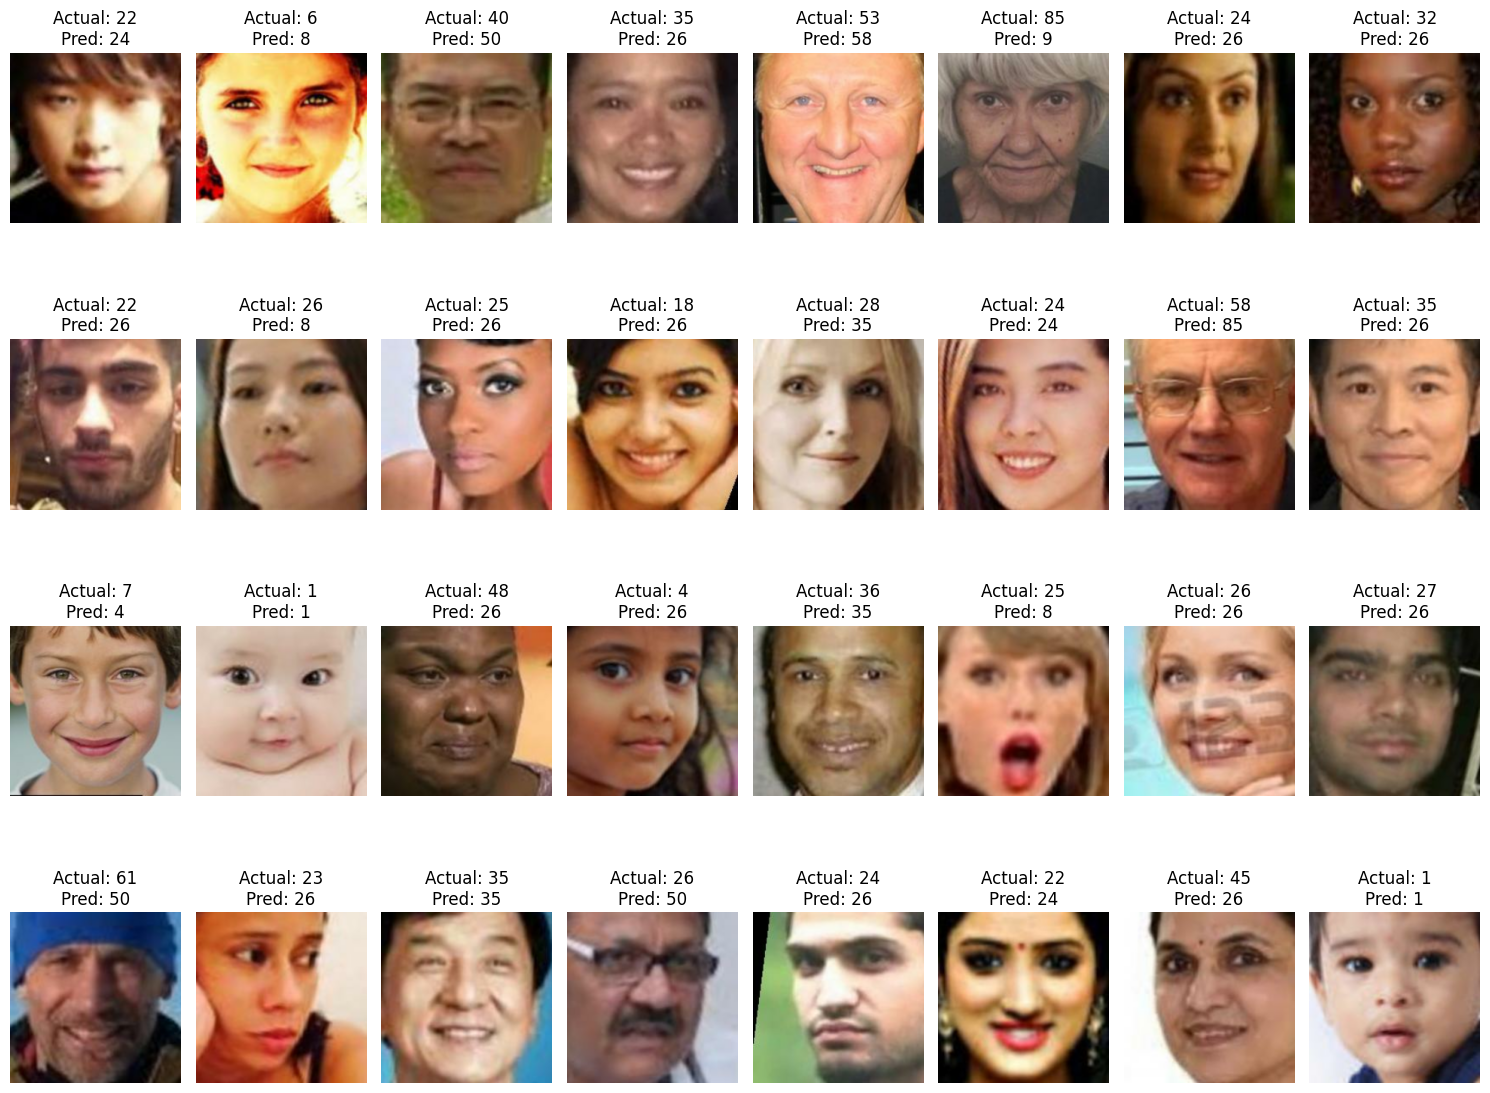

In [ ]:
# # 테스트 결과 시각화 (matplotlib)
# %%
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# 테스트 데이터셋에서 이미지와 실제 나이 라벨 가져오기
for images, y_true in test_age_ds.take(1):
    y_pred = model.predict(images) # 모델의 예측값

    predicted_ages = np.argmax(y_pred, axis=1) # softmax 중 가장 높은 값이 예측값

    n_images = images.shape[0] # 배치 내 이미지 개수
    n_cols = 8
    n_rows = (n_images + n_cols - 1) // n_cols
    plt.figure(figsize=(15, n_rows * 3))

    for i in range(n_images):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Actual: {y_true[i].numpy()}\nPred: {predicted_ages[i]}")
        plt.axis("off")

    plt.tight_layout()

    plt.show()